# Find uracil in a long sequence

In [1]:
import re
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

import pysam

from itertools import cycle
color_cycle = cycle(['r', 'g', 'b', 'orange'])
FS = 12 # fontsize

In [2]:
def read_fast5(fname, single_or_multi_read, get_read_ids=False):
    'from !bsc_szakdoga/github/python_scripts/fast5_analysis.ipynb'
    from ont_fast5_api.fast5_interface import get_fast5_file
    def raw_to_current(rawdata, offset, range_, digitisation):
        return list((np.array(rawdata) + offset) * range_ / digitisation)
    
    if single_or_multi_read not in ['s', 'm']:
        raise ValueError('single_or_multi variable must be "s" or "m".')
    data = []
    read_ids = []
    with get_fast5_file(fname, mode="r") as f:
        for read in f.get_reads():
            ch=read.get_channel_info()
            data.append(raw_to_current(read.get_raw_data(), ch['offset'], ch['range'], ch['digitisation']))
            if single_or_multi_read=='s':
                read_ids.append(read.read_id)
            if single_or_multi_read=='m':
                read_ids.append(read.read_id)
    if single_or_multi_read == 's':
        if get_read_ids:
            return np.array(data[0]), read_ids
        return np.array(data[0]) # single read --> dim=1
    elif single_or_multi_read == 'm':
        if get_read_ids:
            return np.array(data, dtype='object'), read_ids
        return np.array(data, dtype='object')

In [3]:
def read_sam(sam_file_name):
    with open(sam_file_name, 'r') as file:
        sam_files = file.read().split('\n')
    result = []
    for i in range(len(sam_files)-1):
        sam = sam_files[i].split('\t')
        if len(sam)==31:
            read_id = sam[0]
            bases = list(sam[9]) # splitted to characters
            stride = int(sam[21].split(',')[1].split('[')[1])
            move_table = np.array(sam[21].split(',')[2:-2], dtype='int')
            fast5_file = sam[27][3:]
            trim_offset = int(sam[29][3:])
            data = {'fast5_file_name':fast5_file, 'read_id':read_id,
                    'bases':bases, 'move_table':move_table,
                    'stride': stride, 'ts':trim_offset}
            result.append(data)
    print(f'read_sam(): {len(result)} lines in the SAM file.')
    return np.array(result)


def find_read_id_index(string_list, search_string):
    string_array = np.array(string_list)
    index = np.where(np.char.find(string_array, search_string) != -1)[0]
    if len(index) == 1:
        return index[0]
    print(f'Error: no or more indices found; len(index)={len(index)}')
    return None

def split_raw_signal(raw_signal, move_table, stride):
    start_of_bases = (np.where(move_table == 1)[0]) * stride
    signals = [raw_signal[i:j] for i, j in zip(start_of_bases, start_of_bases[1:])]
    mean_signals = [np.mean(raw_signal[i:j]) for i, j in zip(start_of_bases, start_of_bases[1:])]
    return start_of_bases, signals, mean_signals

def replace_T_to_U(data):
    for record in data:
        record['bases'] = ['T/U' if base == 'T' else base for base in record['bases']]
    return np.array(data)

---
# Uracil

In [4]:
path_to_Uracil_sam = '/v/projects/nanopore/balazs/data/uracil_0504/'
path_to_Uracil_fast5 = '/v/projects/nanopore/agnes/signal_visualization/uracil0504/guppy/workspace/'

U_sam_files = glob(path_to_Uracil_sam+'*0.sam')
U_sam_files = sorted(U_sam_files, key=lambda x: int(re.search(r'_(\d+)_0\.sam$', x).group(1)))

U_fast5_files = glob(path_to_Uracil_fast5+'*.fast5')

### Example read

In [5]:
# Read SAM file and fast5 file
data = read_sam(U_sam_files[2])
index_of_fast5 = 27
fast5_file_path = path_to_Uracil_fast5 + data[index_of_fast5]['fast5_file_name']
fast5_signals, read_ids = read_fast5(fast5_file_path, 'm', get_read_ids=True)

read_sam(): 3739 lines in the SAM file.


In [6]:
# Replace timin to uracil
data = replace_T_to_U(data)

In [7]:
# choose the first base list
base_list = data[index_of_fast5]['bases']

In [8]:
# find the index of all uracil
u_indices = [i for i, base in enumerate(base_list) if base == 'T/U']

In [9]:
# calculate the distances
distances = np.diff(u_indices)

In [10]:
# Find the greatest number with greatest neighbors and return its position
def find_the_greatest_neighbors(dst):
    'Squared geometric mean'
    geom_mean_sq = []
    for i in range(len(dst)-1):
        geom_mean_sq.append(dst[i]*dst[i+1] )
    return np.argmax(geom_mean_sq)+1

position = find_the_greatest_neighbors(distances)
print(f"The position: {position}")
print(f"Distances: {distances[position-2: position+2]}")

The position: 158
Distances: [ 7 15 20  1]


In [11]:
distances

array([14,  1,  4,  1,  4,  2,  1,  3,  3,  2,  3,  6,  3,  8,  3,  1,  5,
        1,  1,  4,  4,  9,  5, 21,  4,  1,  2,  3,  6,  2,  4,  9,  2,  3,
        4,  6,  2, 12,  3,  4,  5,  4,  7,  2,  4,  1,  1,  4,  4,  1,  1,
        8,  6, 11,  2,  1,  2, 16,  3,  2,  1,  9,  7,  1,  4,  6,  6,  2,
       10,  2,  5,  2,  6,  3,  2, 10,  1, 16,  1,  3,  1,  3,  6,  4,  1,
        5, 10,  4,  2,  7,  2,  4,  1,  1,  4,  4,  8,  6,  5,  2,  2, 11,
        2,  2,  3,  1,  2,  1,  3,  7,  5,  2,  3,  2,  3,  4,  7,  2, 14,
        1,  4,  2,  8,  1,  3,  9,  2,  1,  3,  6,  1,  6,  5,  2,  4,  3,
        3, 12,  8,  3, 11,  7, 23,  1,  9,  2,  1,  2,  7,  3,  5,  6, 10,
        8,  2,  4,  7, 15, 20,  1, 11,  7,  1,  4,  1,  3,  3,  6,  1,  2,
        3, 21,  4, 21,  2,  2,  1,  3, 17,  3,  1,  3, 11,  6,  5,  1,  1,
       11,  2,  6,  1, 11,  2,  5,  3,  4,  2,  3,  3, 11,  4,  1,  2,  8,
        1,  3, 12,  1, 10,  6, 12,  6,  4, 18,  3, 12,  2,  1,  1,  6,  2,
        5,  8,  2,  5,  5

In [12]:
#base_list[u_indices[position]-distances[position-1]: u_indices[position]+distances[position]+1]

---

In [13]:
read_id_index = find_read_id_index(read_ids, data[index_of_fast5]['read_id'])
signal = fast5_signals[read_id_index][data[index_of_fast5]['ts']:]
start_of_bases, splitted_signal, mean_signals = split_raw_signal(signal, 
                                                                 data[index_of_fast5]['move_table'], 
                                                                 data[index_of_fast5]['stride'])
cum_sum_mv = np.cumsum(data[index_of_fast5]['move_table'])


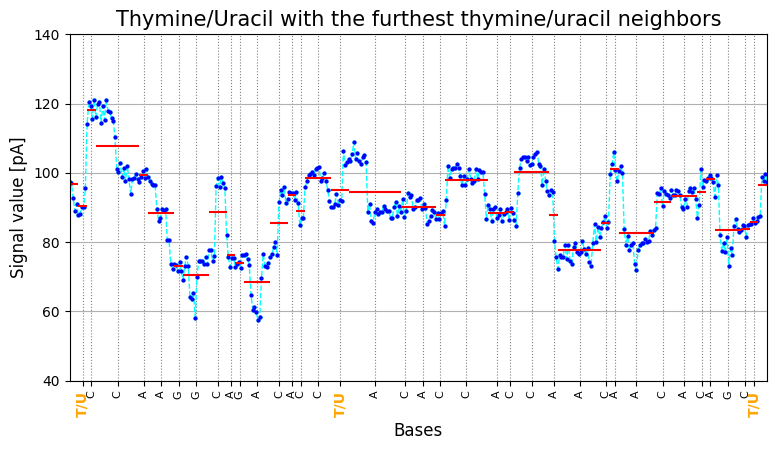

In [14]:
# Plot
mv_idx = np.where((cum_sum_mv > u_indices[position]-distances[position-1]) &
                  (cum_sum_mv <= u_indices[position]+distances[position]+2) )[0]


xlim_min = (mv_idx * data[index_of_fast5]['stride'])[0]
xlim_max = (mv_idx * data[index_of_fast5]['stride'])[-1]


plt.figure(figsize=(9, 4.5))
plt.xlim(xlim_min-5, xlim_max)
plt.ylim(40,150)
plt.plot(signal, 'o--', color='cyan', markersize=2, linewidth=1)
plt.plot(signal, 'o', color='blue', markersize=2)

plt.hlines(mean_signals, start_of_bases[:-1], start_of_bases[1:], color='red')
"""
x = np.array([start_of_bases[:-1], start_of_bases[1:]]).mean(axis=0)
where = np.where((start_of_bases <= xlim_max) & (start_of_bases>=xlim_min))[0]

for i in range(where[0], where[-1]):
    if i == u_indices[position]:
        plt.text(x[i]-8, mean_signals[i]+1, data[index_of_fast5]['bases'][i], color='orange', fontsize=20)
    elif i in [u_indices[position-1],  u_indices[position+1]]:
        plt.text(x[i]-6, mean_signals[i]+1, data[index_of_fast5]['bases'][i], color='orange', fontsize=15)
    else:
        plt.text(x[i]-1, mean_signals[i]+1, data[index_of_fast5]['bases'][i], color='red')
"""     

xtick_positions = np.array([start_of_bases[:-1], start_of_bases[1:]]).mean(axis=0)
xtick_bases = data[index_of_fast5]['bases'][:-1]  
in_range = (xtick_positions >= xlim_min) & (xtick_positions <= xlim_max)
xtick_positions = xtick_positions[in_range]
xtick_bases = np.array(xtick_bases)[in_range]

xtick_positions = np.array([start_of_bases[:-1], start_of_bases[1:]]).mean(axis=0)
xtick_bases = data[index_of_fast5]['bases'][:-1]

in_range = (xtick_positions >= xlim_min) & (xtick_positions <= xlim_max)
xtick_positions = xtick_positions[in_range][:-1]
xtick_bases = np.array(xtick_bases)[in_range][:-1]

ax = plt.gca()
ax.set_xticks(xtick_positions)
ax.set_xticklabels(xtick_bases, rotation=90, fontsize=8)

for tick, base, pos in zip(ax.get_xticklabels(), xtick_bases, xtick_positions):
    if base == 'T/U':  
        tick.set_color('orange')
        tick.set_fontsize(10)
        tick.set_fontweight('bold')


plt.title(f'Thymine/Uracil with the furthest thymine/uracil neighbors', fontsize=FS+3)
plt.xlabel('Bases', fontsize=FS)
plt.ylabel('Signal value [pA]', fontsize=FS)
plt.grid(axis='y')
plt.grid(axis='x', ls='dotted', c='gray')
plt.ylim(40,140)
plt.savefig('figures/uracil_alone.pdf', bbox_inches='tight')

----

In [15]:
def find_pattern(bases, pattern):
    matches = []
    pat_len = len(pattern)
    for i in range(len(bases) - pat_len + 1):
        if bases[i:i+pat_len] == pattern:
            matches.append(i) 
    return matches


In [16]:
new_pos = find_pattern(base_list, ['T/U', 'A', 'A', 'A', 'A', 'T/U', 'G', 'G', 'A', 'A', 'T/U'])[0]
new_pos

1083

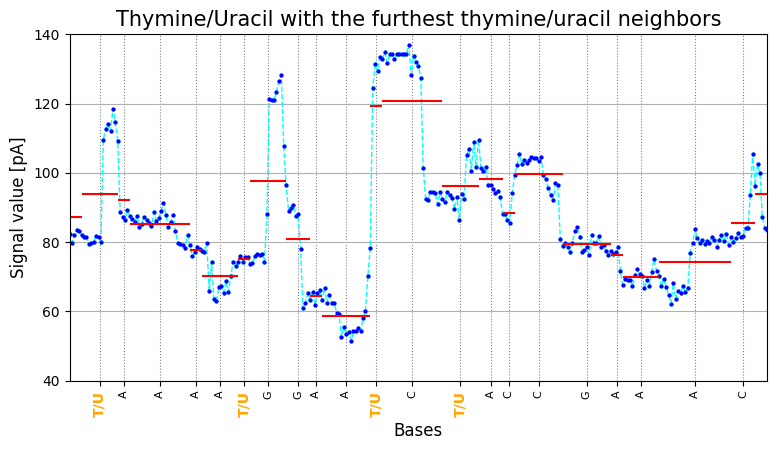

In [17]:
# Plot
mv_idx = np.where((cum_sum_mv > new_pos) &
                  (cum_sum_mv <= new_pos+23) )[0]


xlim_min = (mv_idx * data[index_of_fast5]['stride'])[0]
xlim_max = (mv_idx * data[index_of_fast5]['stride'])[-1]


plt.figure(figsize=(9, 4.5))
plt.xlim(xlim_min-5, xlim_max)
plt.ylim(40,150)
plt.plot(signal, 'o--', color='cyan', markersize=2, linewidth=1)
plt.plot(signal, 'o', color='blue', markersize=2)

plt.hlines(mean_signals, start_of_bases[:-1], start_of_bases[1:], color='red')

xtick_positions = np.array([start_of_bases[:-1], start_of_bases[1:]]).mean(axis=0)
xtick_bases = data[index_of_fast5]['bases'][:-1]  
in_range = (xtick_positions >= xlim_min) & (xtick_positions <= xlim_max)
xtick_positions = xtick_positions[in_range]
xtick_bases = np.array(xtick_bases)[in_range]

xtick_positions = np.array([start_of_bases[:-1], start_of_bases[1:]]).mean(axis=0)
xtick_bases = data[index_of_fast5]['bases'][:-1]

in_range = (xtick_positions >= xlim_min) & (xtick_positions <= xlim_max)
xtick_positions = xtick_positions[in_range][:-1]
xtick_bases = np.array(xtick_bases)[in_range][:-1]

ax = plt.gca()
ax.set_xticks(xtick_positions)
ax.set_xticklabels(xtick_bases, rotation=90, fontsize=8)

for tick, base, pos in zip(ax.get_xticklabels(), xtick_bases, xtick_positions):
    if base == 'T/U':  
        tick.set_color('orange')
        tick.set_fontsize(10)
        tick.set_fontweight('bold')


plt.title(f'Thymine/Uracil with the furthest thymine/uracil neighbors', fontsize=FS+3)
plt.xlabel('Bases', fontsize=FS)
plt.ylabel('Signal value [pA]', fontsize=FS)
plt.grid(axis='y')
plt.grid(axis='x', ls='dotted', c='gray')
plt.ylim(40,140)
plt.savefig('figures/uracil_random_pos.pdf', bbox_inches='tight')